Reference: RL-Adventure https://github.com/higgsfield/RL-Adventure-2/blob/master/3.ppo.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


### Actor and critic NN

In [4]:
# (variales in CAPTICAL are global variables)
N_STATES  = 243
N_ACTIONS = 39
HIDDEN_UNITS = 512

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

In [6]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(N_STATES, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(N_STATES, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.LayerNorm(HIDDEN_UNITS),
            nn.Linear(HIDDEN_UNITS, N_ACTIONS)
        )
        self.log_std = nn.Parameter(torch.ones(1, N_ACTIONS) * 0.0)
        self.apply(init_weights)
    
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [7]:
NET = Net().to(device)

In [8]:
LEARNING_RATE = 0.0003
OPTIMIZER = optim.Adam(NET.parameters(), lr=LEARNING_RATE )

### Test: Actor-Critics NN interacting with Unity

In [9]:
ENV = UnityEnvironment(file_name= None, base_port=5004)

In [10]:
ENV.reset()
behavior_names = list(ENV.behavior_specs.keys())
BEHAVIOR_NAME = behavior_names[0]
print(BEHAVIOR_NAME)

Walker?team=0


In [11]:
DecisionSteps, TerminalSteps = ENV.get_steps(BEHAVIOR_NAME)

In [12]:
s = DecisionSteps.obs[0]
print(s.shape)

(10, 243)


In [13]:
s = torch.FloatTensor(s)       
dist, value = NET(s.to(device))
print(dist, "\n", value)

Normal(loc: torch.Size([10, 39]), scale: torch.Size([10, 39])) 
 tensor([[1.7525],
        [1.3020],
        [1.8764],
        [1.7034],
        [1.7539],
        [1.6710],
        [2.0807],
        [1.8870],
        [2.0875],
        [0.3530]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [14]:
a = dist.sample() 
log_prob = dist.log_prob(a)
print(a, "\n", log_prob)

tensor([[-0.9380, -2.7641, -0.6294,  1.9791,  1.2407, -1.3509, -0.9109, -1.9831,
          3.7667,  0.8306, -1.9467, -1.6690, -3.2711,  0.0184,  2.8337,  2.0580,
         -2.7193,  0.4982, -2.0121, -2.2045,  0.8556, -0.9744,  1.3541, -2.2523,
          3.1774,  0.1733, -1.1508, -0.2490,  1.0795,  3.1678, -1.2401,  2.3537,
          1.3906,  0.0341, -0.3109, -6.1943,  2.8592, -1.7465, -1.9488],
        [ 1.6272, -0.7344, -1.5027,  4.3552, -0.3052, -1.4030,  3.0113,  0.7138,
          2.7246,  3.0524,  1.2059,  1.3404, -2.7189, -0.3873,  1.7334, -2.1341,
         -2.4745,  0.0732,  0.9696, -0.7626,  3.3580, -1.2621,  0.7931, -1.1350,
          0.5355,  2.8415, -2.3722,  0.0333,  2.0301,  1.0356, -0.3242,  1.7679,
          1.4561, -1.4792, -3.0903, -2.5798,  4.9630, -0.4615, -4.3254],
        [-1.5545,  0.8662, -2.7014,  2.2875, -0.2089, -0.8912,  0.6527,  0.2810,
          0.0528, -0.0460, -1.0514, -1.0024, -2.1966, -0.4515, -0.0266,  3.6249,
         -3.4321,  0.4266,  1.2281, -1.0693,

In [15]:
a = a.cpu().detach().numpy()
a = ActionTuple(np.array(a, dtype=np.float32))
ENV.set_actions(BEHAVIOR_NAME, a)   
ENV.step()
a = a._continuous #convert from ActionTuple to np.array
a = torch.FloatTensor(a) # convert from np.array to Tensor

In [16]:
ENV.close()

### Interacts with Unity to collect training data 

In [17]:
def Interact_with_Unity_one_step (DecisionSteps):
    # ENV and NET are global variables        
    s = DecisionSteps.obs[0]  
    s = torch.FloatTensor(s)       
    dist, value = NET(s.to(device))
    a = dist.sample() 
    log_prob = dist.log_prob(a)
    
    a = a.cpu().detach().numpy()
    a = ActionTuple(np.array(a, dtype=np.float32))
    ENV.set_actions(BEHAVIOR_NAME, a)   
    ENV.step()
    a = a._continuous #convert from ActionTuple to np.array
    a = torch.FloatTensor(a) # convert from np.array to Tensor
    return s, value, a, log_prob

In [18]:
def Collect_REWARDS_and_MASKS (step, AgentSteps, flag): 
    #flag=1:decision, 0: terminal steps
    #REWARDS, MASKS, NEXT_STATES are gloable variables
    r = AgentSteps.reward
    r = torch.FloatTensor(r).unsqueeze(1)
    s = torch.FloatTensor(AgentSteps.obs[0])
    s = torch.FloatTensor(s).to(device) 
    for idx in range(len(AgentSteps)):
        AgentID = AgentSteps.agent_id[idx]
        REWARDS[step][AgentID]=r[idx]
        MASKS[step][AgentID]= flag
        NEXT_STATES[step][AgentID]=s[idx]

In [19]:
def collect_training_data (print_message):  
    # Interact with Unity INTERACTION_STEPS to collect training data
    # The total number of training data collected (buffer size) is INTERACTION_STEPS*N_AGENTS 
    #ENV, BEHAVIOR_NAME are gloabl variables
    #STATES, ACTIONS, LOG_PROBS, VALUES, REWARDS, MASKS, NEXT_STATES are global variables (tensor array)
    if(print_message):
        print("Collecting ", INTERACTION_STEPS, " training steps from ", N_AGENTS, " agents", end=": ")
    step = 0  
    DecisionSteps, TerminalSteps = ENV.get_steps(BEHAVIOR_NAME)
    while(step < INTERACTION_STEPS): #try to run TIME_HORIZON good steps
        #if we have no decision agents,then continue next loop without increase step
        if(len(DecisionSteps) == 0): 
            ENV.reset() 
            DecisionSteps, TerminalSteps = ENV.get_steps(BEHAVIOR_NAME)
            continue #continue next while loop without increase step
        
        # Interacts with Unity one step
        s, value, a, log_prob = Interact_with_Unity_one_step (DecisionSteps)
        NextDecisionSteps, NextTerminalSteps = ENV.get_steps(BEHAVIOR_NAME)

        #if this or next decision step misses some agents, then do not collect data
        if(len(DecisionSteps)!= N_AGENTS or len(NextDecisionSteps)!= N_AGENTS):
            DecisionSteps, TerminalSteps = NextDecisionSteps, NextTerminalSteps
            continue      #continue next while loop without increase step
        
        #else this and next decision steps includes all agents, collect (s, a, r, s1)
        for idx in range(len(DecisionSteps)):
            #find decision agents and record their state, value and ACTIONS
            AgentID = DecisionSteps.agent_id[idx]
            STATES[step][AgentID]=s[idx]
            VALUES[step][AgentID]=value[idx]
            ACTIONS[step][AgentID]=a[idx]
            LOG_PROBS[step][AgentID]=log_prob[idx]

        #collect reward of this action from next decision and terminal steps
        if(len(NextTerminalSteps) >0):
            #if next step has terminal agents, then collect terminal agents first
            Collect_REWARDS_and_MASKS(step, NextTerminalSteps, 0)
        else:  #else collect r and next state from decision steps
            Collect_REWARDS_and_MASKS(step, NextDecisionSteps, 1)
        
        if(print_message and (step % 500)==0):
            print(step, end=",")
        step = step + 1
        DecisionSteps, TerminalSteps = NextDecisionSteps, NextTerminalSteps
    print()

In [20]:
def compute_gae(next_value):
    value1 = VALUES + [next_value.cpu()]
    gae = 0
    returns = []
    for step in reversed(range(INTERACTION_STEPS )):
        delta = REWARDS[step] + GAMMA*value1[step + 1]*MASKS[step]-value1[step]
        gae = delta + GAMMA*LAMBD*MASKS[step]*gae
        returns.insert(0, gae + VALUES[step])
    return returns

### Test interaction with Unity to collect training data

In [21]:
ENV = UnityEnvironment(file_name= None, base_port=5004)

In [22]:
ENV.reset()
behavior_names = list(ENV.behavior_specs.keys())
BEHAVIOR_NAME = behavior_names[0]
print(BEHAVIOR_NAME)

Walker?team=0


In [23]:
# tensor arrays to store training data (s,a,r,s1) from N_AGENTS performing INTERACTION_STEPS
N_AGENTS = 10  #The number of training scenes in Unity 

INTERACTION_STEPS = 254  #(Walker.yaml 2048) buffer_size=N_AGENTS * INTERACTION_STEPS=20480

a = torch.FloatTensor([[0]]*N_AGENTS ) 
b = torch.FloatTensor([[0]*N_ACTIONS]*N_AGENTS ) 
c = torch.FloatTensor([[0]*N_STATES]*N_AGENTS ) 

VALUES =REWARDS = MASKS = [a]*INTERACTION_STEPS
LOG_PROBS = ACTIONS = [b]*INTERACTION_STEPS
STATES = NEXT_STATES = [c]*INTERACTION_STEPS

In [24]:
collect_training_data(print_message=True)

In [25]:
print(len(LOG_PROBS), LOG_PROBS[0].shape)
print(len(VALUES), VALUES[0].shape)
print(len(REWARDS), REWARDS[0].shape)
print(len(MASKS), MASKS[0].shape)
print(len(STATES), STATES[0].shape)
print(len(ACTIONS), ACTIONS[0].shape)
print(len(NEXT_STATES), NEXT_STATES[0].shape)

254 torch.Size([10, 39])
254 torch.Size([10, 1])
254 torch.Size([10, 1])
254 torch.Size([10, 1])
254 torch.Size([10, 243])
254 torch.Size([10, 39])
254 torch.Size([10, 243])


In [26]:
# send last next state to calculate value
_, next_value = NET(NEXT_STATES[-1].to(device)) 

In [27]:
GAMMA = 0.995
LAMBD = 0.95

In [28]:
RETURNS = compute_gae(next_value)

In [29]:
MERGED_RETURNS   = torch.cat(RETURNS).detach()
MERGED_LOG_PROBS = torch.cat(LOG_PROBS).detach()
MERGED_VALUES    = torch.cat(VALUES).detach()
MERGED_STATES    = torch.cat(STATES) 
MERGED_NEXT_STATES   = torch.cat(NEXT_STATES) 
MERGED_ACTIONS   = torch.cat(ACTIONS)
MERGED_ADVANTAGES = MERGED_RETURNS - MERGED_VALUES

In [30]:
print(len(MERGED_RETURNS), MERGED_RETURNS[0].shape)
print(len(MERGED_LOG_PROBS), MERGED_LOG_PROBS[0].shape)
print(len(MERGED_VALUES), MERGED_VALUES[0].shape)
print(len(MERGED_STATES), MERGED_STATES[0].shape)
print(len(MERGED_NEXT_STATES), MERGED_NEXT_STATES[0].shape)
print(len(MERGED_ACTIONS), MERGED_ACTIONS[0].shape)
print(len(MERGED_ADVANTAGES), MERGED_ADVANTAGES[0].shape)

2540 torch.Size([1])
2540 torch.Size([39])
2540 torch.Size([1])
2540 torch.Size([243])
2540 torch.Size([243])
2540 torch.Size([39])
2540 torch.Size([1])


In [31]:
ENV.close()

### PPO Optimization

In [32]:
def ppo_iter():
    buffer_size = MERGED_STATES.size(0)
    for _ in range(buffer_size// BATCH_SIZE ):
        rand_ids = np.random.randint(0, buffer_size, BATCH_SIZE )
        yield MERGED_STATES[rand_ids, :], MERGED_ACTIONS[rand_ids, :], MERGED_NEXT_STATES[rand_ids, :],\
              MERGED_LOG_PROBS[rand_ids, :], MERGED_RETURNS[rand_ids, :], MERGED_ADVANTAGES[rand_ids, :]

In [33]:
def ppo_update():
    #print("epoch:")
    for epoch in range(N_EPOCH):
        #print(epoch, end = ", ")
        for b_s, b_a, b_s_, b_old_LOG_PROBS, b_return, b_advantage in ppo_iter():
            dist, value = NET(b_s.to(device))       
            critic_loss = (b_return.to(device) - value).pow(2).mean()
            entropy = dist.entropy().mean()
            b_a_new = dist.sample()
            b_new_LOG_PROBS = dist.log_prob(b_a_new)
            ratio = (b_new_LOG_PROBS - b_old_LOG_PROBS.to(device)).exp()
            surr1 = ratio * b_advantage.to(device)
            surr2 = torch.clamp(ratio, 1.0-EPSILON, 1.0+EPSILON) * b_advantage.to(device)
            actor_loss  = - torch.min(surr1, surr2).mean()
            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
            OPTIMIZER.zero_grad()
            loss.backward()
            OPTIMIZER.step()
    return float(critic_loss), float(actor_loss)

### Try one training iteration

In [34]:
ENV = UnityEnvironment(file_name= None, base_port=5004)

In [35]:
ENV.reset()
behavior_names = list(ENV.behavior_specs.keys())
BEHAVIOR_NAME = behavior_names[0]
print(BEHAVIOR_NAME)

Walker?team=0


In [36]:
collect_training_data(print_message=True)

In [37]:
# send last next state to calculate value
_, next_value = NET(NEXT_STATES[-1].to(device)) 

In [38]:
RETURNS = compute_gae(next_value)

In [39]:
MERGED_RETURNS   = torch.cat(RETURNS).detach()
MERGED_LOG_PROBS = torch.cat(LOG_PROBS).detach()
MERGED_VALUES    = torch.cat(VALUES).detach()
MERGED_STATES    = torch.cat(STATES) 
MERGED_NEXT_STATES   = torch.cat(NEXT_STATES) 
MERGED_ACTIONS   = torch.cat(ACTIONS)
MERGED_ADVANTAGES = MERGED_RETURNS - MERGED_VALUES

In [40]:
BATCH_SIZE = 254         #Walker.yaml 2048
BETA = 0.005
EPSILON = 0.2
N_EPOCH = 3

In [41]:
critic_loss, actor_loss = ppo_update()
print(critic_loss, actor_loss)

10.913178443908691 -15.266915321350098


In [42]:
ENV.close()

# Interact with Unity for N steps

In [43]:
MAX_STEPS = 30000    #Walker.yaml 30M
SUMMARY_FREQ = 3000  #Walker.yaml 30K
TIME_HORIZON = 1000  #I do not use this parameter in my porgram

In [44]:
ENV = UnityEnvironment(file_name= None, base_port=5004)

In [45]:
ENV.reset()
BEHAVIOR_NAME = list(ENV.behavior_specs.keys())
BEHAVIOR_NAME = BEHAVIOR_NAME[0]

In [46]:
ActorLossLst = []
CriticLossLst = []
ForwardLossLst = []
steps  = 0 
summary = SUMMARY_FREQ

while (steps < MAX_STEPS):
    #print("Collecting ", INTERACTION_STEPS, " training steps from ", N_AGENTS, " agents", end=": ")
    collect_training_data(print_message=True)
    _, next_value = NET(NEXT_STATES[-1].to(device)) 
    
    print("Compute GAE of these training data set")
    RETURNS = compute_gae(next_value)
    MERGED_RETURNS   = torch.cat(RETURNS).detach()
    MERGED_LOG_PROBS = torch.cat(LOG_PROBS).detach()
    MERGED_VALUES    = torch.cat(VALUES).detach()
    MERGED_STATES    = torch.cat(STATES) 
    MERGED_NEXT_STATES    = torch.cat(NEXT_STATES) 
    MERGED_ACTIONS   = torch.cat(ACTIONS)
    MERGED_ADVANTAGES = MERGED_RETURNS - MERGED_VALUES
    
    print("Optimize NN with PPO")
    critic_loss, actor_loss = ppo_update()
    CriticLossLst.append(critic_loss)
    ActorLossLst.append(actor_loss)
    if(steps > summary):
        print("Already train ", steps, " steps") 
        print("Critic loss = ", round(critic_loss, 2), " Actor loss = ", round(actor_loss, 2))
        summary += SUMMARY_FREQ

    steps += INTERACTION_STEPS*N_AGENTS

Compute GAE of these training data set
Optimize NN with PPO
Compute GAE of these training data set
Optimize NN with PPO
Compute GAE of these training data set
Optimize NN with PPO
Already train  5080  steps
Critic loss =  0.94  Actor loss =  -16.25
Compute GAE of these training data set
Optimize NN with PPO
Already train  7620  steps
Critic loss =  0.3  Actor loss =  -16.1
Compute GAE of these training data set
Optimize NN with PPO
Already train  10160  steps
Critic loss =  0.37  Actor loss =  -16.59
Compute GAE of these training data set
Optimize NN with PPO
Already train  12700  steps
Critic loss =  0.11  Actor loss =  -16.25
Compute GAE of these training data set
Optimize NN with PPO
Already train  15240  steps
Critic loss =  0.15  Actor loss =  -16.26
Compute GAE of these training data set
Optimize NN with PPO
Compute GAE of these training data set
Optimize NN with PPO
Already train  20320  steps
Critic loss =  0.11  Actor loss =  -16.38
Compute GAE of these training data set
Optim

In [47]:
ENV.close()

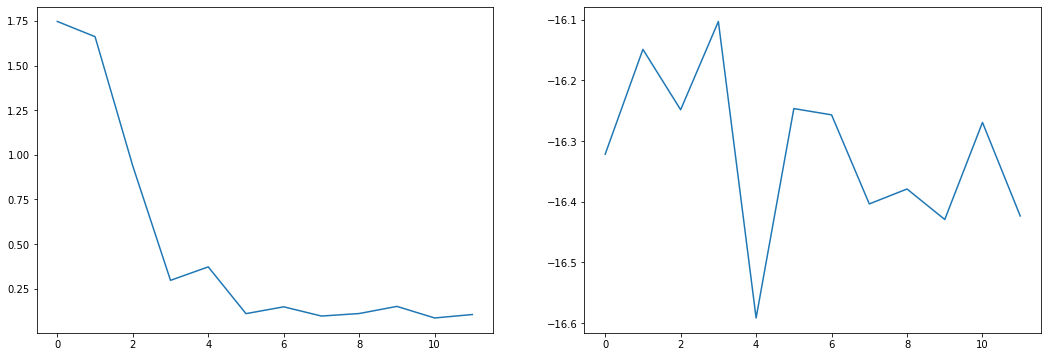

In [48]:
fig=plt.figure(figsize=(18, 6))
fig.add_subplot(1, 2, 1)  # 1 row, 2 columns
plt.plot(CriticLossLst)

fig.add_subplot(1, 2, 2) 
plt.plot(ActorLossLst)

plt.show()